In [148]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import random
import shutil
from tqdm import tqdm

## 0. 상숫값 및 경로 설정

In [152]:
image_dir = 'images/' #1.이미지 불러오기 - 이미지 폴더 디렉토리
sample_ratio = 0.05 #1.이미지 불러오기 - 샘플링 비율
pca_threshold = 0.95 #3. PCA - 적합한 차원 수 찾기
save_dir = 'features1/' #6. 데이터 저장 - 데이터 저장 디렉토리
features_name = 'features'
data_dir = 'features1/features.csv'
result_dir = 'results11/'

## 1. 모델 불러오기

In [4]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

## 2. 이미지 불러오기

In [5]:
# 파일명을 담는 리스트
file_names = []

with os.scandir(image_dir) as files:
    for file in files:
        # .jpg .png 등 확장자명이 'g'로 끝나는 파일들 모두 읽기
        if file.name.endswith('g'):
            file_names.append(image_dir + file.name)
            
# 샘플링 수행 ()
if sample_ratio < 1:
    file_names = random.sample(file_names, int(len(file_names) * sample_ratio))

## 3. 이미지 별 특징값 추출

In [12]:
def extract_features(file_name, model, image_size = (224, 224)):
    # load the image as a 224x224 array
    img = load_img(file_name, target_size = image_size)
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    img = img.reshape(1, image_size[0], image_size[1] , 3) 
    # prepare image for model
    imgx = preprocess_input(img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [61]:
data = {}

for file in tqdm(file_names):
    feat = extract_features(file, model)
    data[file] = feat

100%|████████████████████████████████████████████████████████████████████████████████| 544/544 [01:36<00:00,  5.64it/s]


## 4. 특징값 저장

In [62]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [63]:
def save_data(data, file_name, save_dir):
    try:
        save_name = save_dir + file_name + '.csv'
        data.to_csv(save_name)
    except:
        createFolder(save_dir)

In [64]:
filenames = np.array(list(data.keys()))
features = np.array(list(data.values())).reshape(-1,4096)
df = pd.DataFrame(features, index = filenames)

save_data(df, features_name, save_dir)

## 5. 특징값 로드

In [85]:
df = pd.read_csv(data_dir, header = 0, index_col = 0)
filenames = df.index
features = df.values

## 6. PCA - 적합한 차원 수 찾기

In [86]:
def pca_test(data, threshold):
    pca = PCA(n_components = 544, random_state = 2021) 
    pca.fit_transform(data)
    
    ratio = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(ratio >= threshold) + 1    
    return (d, ratio[d - 1])

In [89]:
pca_component = pca_test(features, pca_threshold)
pca_component

(325, 0.950168518697469)

## 7. 클러스터링 수행

In [92]:
def clustering_data(data, pca_components = 300, target_cluster = 10):
    pca = PCA(n_components = pca_components, random_state=2021)
    x = pca.fit_transform(data)
    
    kmeans = KMeans(n_clusters=target_cluster, random_state=22)
    return kmeans.fit(x)

In [104]:
clu_data = clustering_data(features, pca_component[0], target_cluster = 10)

## 8. 거리에 따른 클러스터 수 선정

In [114]:
def show_inertia(data, s, e):
    sse = []
    list_k = list(range(s, e))
    for k in tqdm(range(s, e)):
        km = KMeans(n_clusters=k, random_state=22)
        km.fit_transform(data)
        sse.append(km.inertia_)
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse)
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:20<00:00,  2.01s/it]


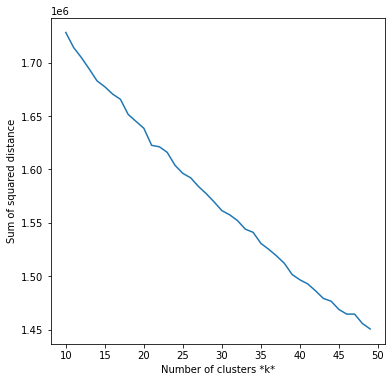

In [115]:
show_inertia(features, 10, 50)

In [ ]:
# 적합한 클러스터 수 선정
clu_data = clustering_data(features, pca_component[0], target_cluster = 30)

## 9. 이미지 그룹화

In [120]:
def grouping_by_clusters(image_file_names, labels):
    groups = {}
    for file, cluster in zip(image_file_names, labels):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups

In [119]:
groups = grouping_by_clusters(filenames, clu_data.labels_)

## 10. 데이터 시각화

In [122]:
def view_cluster(groups, cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 24:
        print(f"Clipping cluster size from {len(files)} to 24")
        files = files[:24]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(8, 8,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

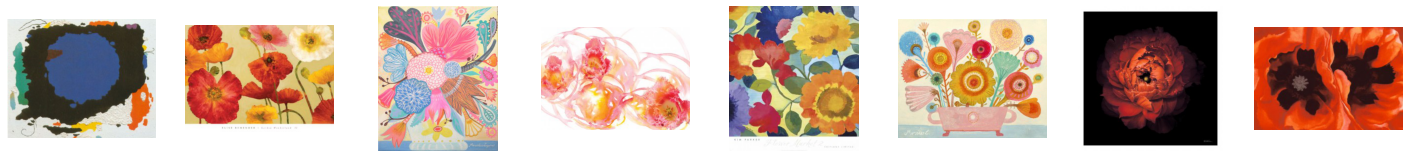

In [141]:
view_cluster(groups, 29)

## 11. 데이터 저장

In [149]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [150]:
def save_data(groups, result_dir):
    for clusters, files in groups.items():
        createFolder(result_dir + str(clusters))
        for file in files:
            shutil.copyfile(file, result_dir + str(clusters) + '/' + file.rsplit('/')[1])

In [153]:
save_data(groups, result_dir)